
# Rota Inteligente: Otimização de Entregas com IA para Sabor Express


### 1. Configuração do Ambiente e Importação de Bibliotecas

Esta célula inicial configura o ambiente Python importando as bibliotecas essenciais para o projeto:
- `networkx` para criação e manipulação de grafos.
- `matplotlib` para visualização de dados.
- `numpy` para operações numéricas.
- `random` e `math` para geração de dados e cálculos auxiliares.
- `sklearn.cluster.KMeans` para aplicar o algoritmo de agrupamento K-Means.

In [254]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from sklearn.cluster import KMeans

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Modelagem do Cenário Urbano como Grafo

Modela a cidade como um grafo não direcionado em grade 10x10.
- Nós representam cruzamentos.
- Arestas representam ruas (horizontal, vertical, diagonal).
- Pesos das arestas simulam distâncias em km com variação aleatória ('fator de realismo').


Grafo criado com 100 nós e 342 arestas.
Pesos das arestas representam distâncias em km, variando aleatoriamente.
(Base: 0.5 km para H/V, 0.71 km para diagonal, multiplicados por fator [0.9, 1.5])


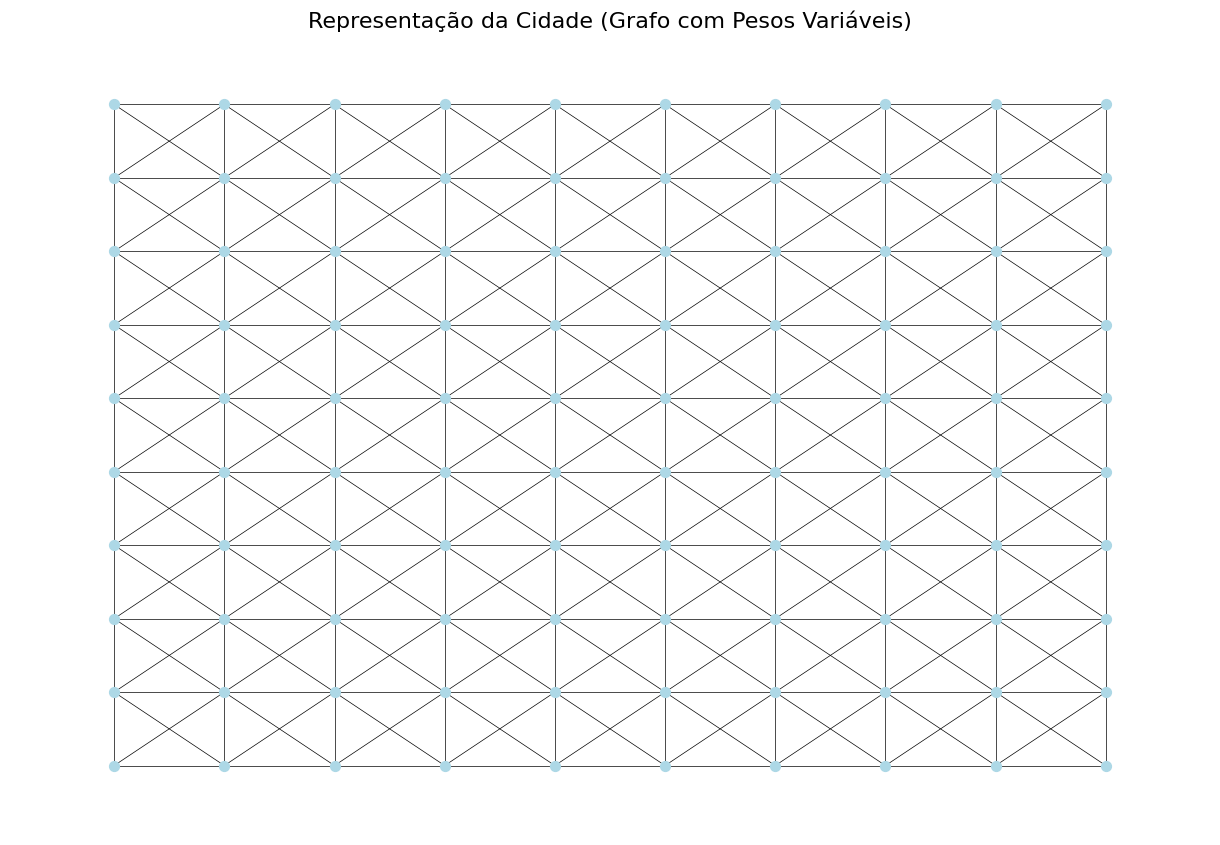

In [255]:
# Criando o grafo
G = nx.Graph()
grid_size = 10

# Fator de Escala: Cada unidade no grid representa 0.5 km.
FATOR_ESCALA_KM = 0.5

# Adicionando nós e suas posições
pos = {}
for i in range(grid_size):
    for j in range(grid_size):
        node_id = i * grid_size + j
        G.add_node(node_id)
        pos[node_id] = (i, j)

# Adicionando arestas com pesos aleatórios em km
for i in range(grid_size):
    for j in range(grid_size):
        node_id = i * grid_size + j

        # Conecta com o nó à direita (Horizontal)
        if i < grid_size - 1:
            right_node_id = (i + 1) * grid_size + j
            base_dist = 1.0
            fator_realismo = random.uniform(0.9, 1.5) # Variação aleatória
            distancia_km = base_dist * fator_realismo * FATOR_ESCALA_KM
            G.add_edge(node_id, right_node_id, weight=distancia_km)

        # Conecta com o nó abaixo (Vertical)
        if j < grid_size - 1:
            bottom_node_id = i * grid_size + (j + 1)
            base_dist = 1.0
            fator_realismo = random.uniform(0.9, 1.5) # Variação aleatória
            distancia_km = base_dist * fator_realismo * FATOR_ESCALA_KM
            G.add_edge(node_id, bottom_node_id, weight=distancia_km)

        # Conecta com o nó na diagonal inferior-direita
        if i < grid_size - 1 and j < grid_size - 1:
            diag_node_id = (i + 1) * grid_size + (j + 1)
            base_dist = math.sqrt(2)
            fator_realismo = random.uniform(0.9, 1.5) # Variação aleatória
            distancia_km = base_dist * fator_realismo * FATOR_ESCALA_KM
            G.add_edge(node_id, diag_node_id, weight=distancia_km)

        # Adiciona conexão diagonal inferior-esquerda
        if i > 0 and j < grid_size - 1:
             diag_node_id = (i - 1) * grid_size + (j + 1)
             base_dist = math.sqrt(2)
             fator_realismo = random.uniform(0.9, 1.5) # Variação aleatória
             distancia_km = base_dist * fator_realismo * FATOR_ESCALA_KM
             G.add_edge(node_id, diag_node_id, weight=distancia_km)


print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
print(f"Pesos das arestas representam distâncias em km, variando aleatoriamente.")
print(f"(Base: {1.0 * FATOR_ESCALA_KM} km para H/V, {math.sqrt(2) * FATOR_ESCALA_KM:.2f} km para diagonal, multiplicados por fator [0.9, 1.5])")

# Visualização inicial do grafo
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', width=0.5)
plt.title("Representação da Cidade (Grafo com Pesos Variáveis)", fontsize=16)
plt.show()

### 3. Simulação de Pedidos e Localização do Depósito

Define-se a localização do depósito central da 'Sabor Express' (`depot_node`) e geram-se aleatoriamente `num_deliveries` pontos de entrega distintos no grafo, simulando os pedidos dos clientes (`delivery_nodes`). A visualização mostra o mapa inicial com o depósito e os locais de entrega.


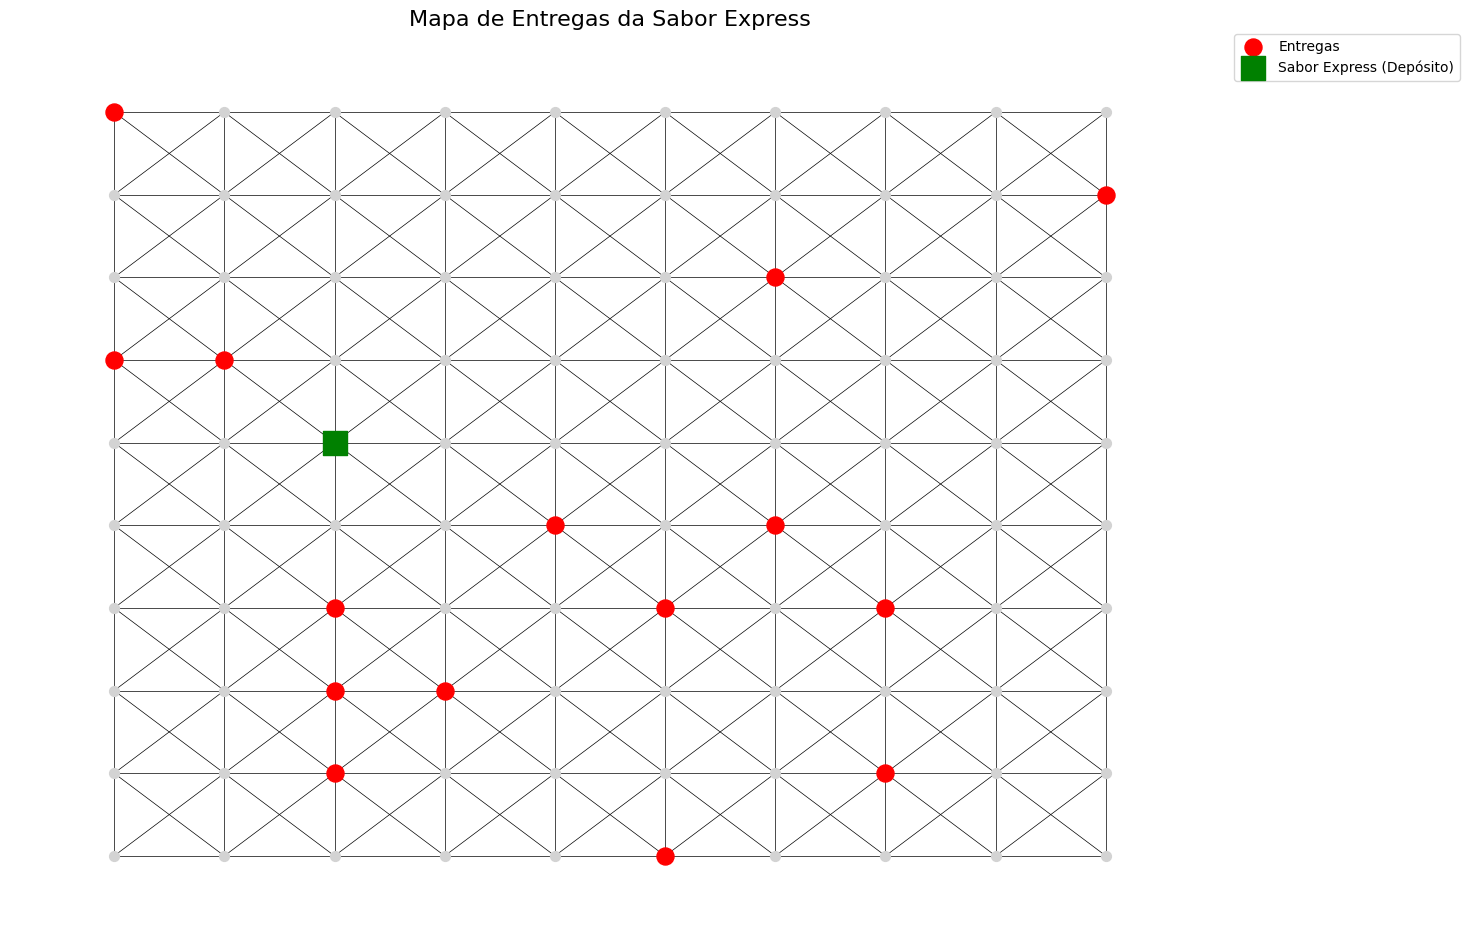

In [256]:
# Definindo o ponto de partida (Sabor Express)
depot_node = 25 # Ex: nó na posição (2, 5)

# Gerando pontos de entrega aleatórios
num_deliveries = 15
all_nodes = list(G.nodes())
all_nodes.remove(depot_node) # Garante que o ponto de entrega não seja o próprio depósito
delivery_nodes = random.sample(all_nodes, num_deliveries)

# Visualizando o depósito e pontos de entrega
plt.figure(figsize=(12, 9))
nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightgray', width=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=delivery_nodes, node_color='red', node_size=150, label='Entregas')
nx.draw_networkx_nodes(G, pos, nodelist=[depot_node], node_color='green', node_size=300, node_shape='s', label='Sabor Express (Depósito)')
plt.title("Mapa de Entregas da Sabor Express", fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

### 4. Agrupamento de Entregas por Proximidade (Clustering com K-Means)

Para otimizar a logística e distribuir o trabalho entre múltiplos entregadores (`num_clusters`), aplica-se o algoritmo K-Means. Este algoritmo agrupa os pontos de entrega em clusters (`clustered_deliveries`) com base na proximidade geográfica de suas coordenadas no grafo. A visualização mostra os clusters identificados por cores diferentes.

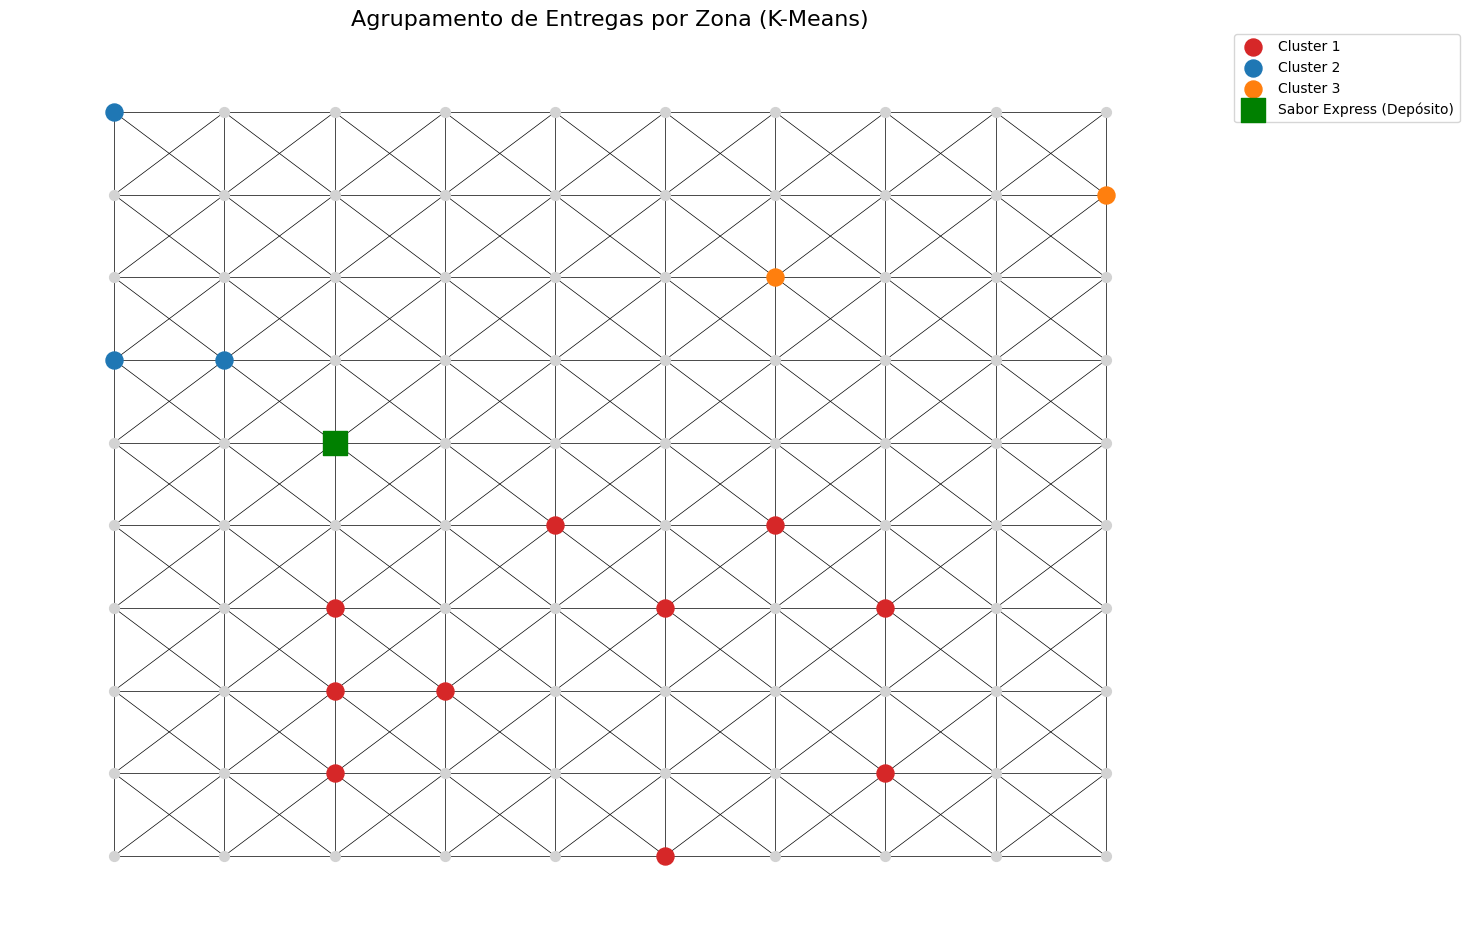

In [257]:
# Número de clusters (entregadores)
num_clusters = 3

# Extraindo as coordenadas dos pontos de entrega
delivery_coords = [pos[node] for node in delivery_nodes]

# Criando e treinando o modelo K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(delivery_coords)

# Obtendo os rótulos de cluster
cluster_labels = kmeans.labels_

# Organizando os nós de entrega por cluster
clustered_deliveries = [[] for _ in range(num_clusters)]
for i, node_id in enumerate(delivery_nodes):
    cluster_id = cluster_labels[i]
    clustered_deliveries[cluster_id].append(node_id)

# Visualizando os clusters
plt.figure(figsize=(12, 9))
nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightgray', width=0.5)
colors = ['#d62728', '#1f77b4', '#ff7f0e']
for i in range(num_clusters):
    nx.draw_networkx_nodes(G, pos, nodelist=clustered_deliveries[i], node_color=colors[i], node_size=150, label=f'Cluster {i+1}')
nx.draw_networkx_nodes(G, pos, nodelist=[depot_node], node_color='green', node_size=300, node_shape='s', label='Sabor Express (Depósito)')
plt.title("Agrupamento de Entregas por Zona (K-Means)", fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()

### 5. Otimização de Rota Intra-Cluster (Algoritmo A*)

Para cada cluster, determina-se a rota mais eficiente (`find_optimized_route`). A função implementa uma heurística 'gulosa' para resolver o Problema do Caixeiro Viajante (TSP) de forma aproximada:
1. Inicia no depósito.
2. Identifica o ponto de entrega não visitado mais próximo dentro do cluster.
3. Calcula o caminho mais curto até esse ponto usando o algoritmo A* (`nx.astar_path`).
4. Repete os passos 2 e 3 até visitar todos os pontos do cluster.
5. Calcula o caminho de retorno ao depósito usando A*.

A heurística usada no A* é a distância euclidiana direta entre os pontos, escalada para km. A função retorna a sequência completa de nós da rota e a distância total percorrida.

In [258]:
def find_optimized_route(graph, start_node, cluster_nodes):
    """
    Encontra uma rota otimizada para um cluster usando uma abordagem gulosa.
    Usa A* para encontrar o caminho mais curto entre os pontos.
    """
    if not cluster_nodes:
        return [], 0

    unvisited = list(cluster_nodes)
    current_node = start_node
    full_path = [start_node]
    total_distance = 0

    # Heurística para A*: distância euclidiana (escalada para km)
    def heuristic(u, v):
        return math.sqrt((pos[u][0] - pos[v][0])**2 + (pos[u][1] - pos[v][1])**2) * FATOR_ESCALA_KM

    last_node_in_segment = start_node
    while unvisited:
        # Encontra o nó não visitado mais próximo
        next_node = min(unvisited, key=lambda node: nx.astar_path_length(graph, current_node, node, heuristic=heuristic, weight='weight'))

        # Calcula o caminho A* para o próximo nó
        path_segment = nx.astar_path(graph, current_node, next_node, heuristic=heuristic, weight='weight')
        segment_distance = nx.astar_path_length(graph, current_node, next_node, heuristic=heuristic, weight='weight')

        # Adiciona ao caminho total
        full_path.extend(path_segment[1:])
        total_distance += segment_distance

        # Atualiza o estado
        current_node = next_node
        unvisited.remove(next_node)
        last_node_in_segment = next_node

    # Adiciona o caminho de volta ao depósito
    if last_node_in_segment != start_node:
        path_back_to_depot = nx.astar_path(graph, current_node, start_node, heuristic=heuristic, weight='weight')
        distance_back = nx.astar_path_length(graph, current_node, start_node, heuristic=heuristic, weight='weight')
        full_path.extend(path_back_to_depot[1:])
        total_distance += distance_back

    # Tratamento para cluster vazio
    if len(full_path) > 1 and full_path[0] == full_path[-1] and len(set(full_path)) == 1:
         full_path = [start_node]

    return full_path, total_distance


# Calculando as rotas para cada cluster
optimized_routes = []
total_distances = []

for i in range(num_clusters):
    route, distance = find_optimized_route(G, depot_node, clustered_deliveries[i])
    optimized_routes.append(route)
    total_distances.append(distance)
    print(f"Rota otimizada para o Cluster {i+1}:")
    route_str = ' -> '.join(map(str, route))
    if len(route_str) > 100:
        route_str = route_str[:50] + " ... " + route_str[-50:]
    print(f"  - Sequência de nós visitados: {route_str}")
    print(f"  - Distância total: {distance:.2f} km")
    print("-" * 30)

Rota otimizada para o Cluster 1:
  - Sequência de nós visitados: 25 -> 24 -> 23 -> 22 -> 21 -> 32 -> 33 -> 44 -> 53 ... 72 -> 71 -> 61 -> 50 -> 41 -> 42 -> 33 -> 24 -> 25
  - Distância total: 12.77 km
------------------------------
Rota otimizada para o Cluster 2:
  - Sequência de nós visitados: 25 -> 16 -> 6 -> 7 -> 8 -> 9 -> 8 -> 17 -> 26 -> 25
  - Distância total: 5.61 km
------------------------------
Rota otimizada para o Cluster 3:
  - Sequência de nós visitados: 25 -> 35 -> 46 -> 57 -> 67 -> 77 -> 88 -> 98 -> 88 -> 77 -> 66 -> 56 -> 46 -> 35 -> 25
  - Distância total: 9.17 km
------------------------------


### 6. Visualização Final das Rotas Otimizadas

Gera a visualização final combinada:
- O grafo da cidade como fundo.
- O depósito (quadrado verde).
- Os pontos de entrega (círculos coloridos por cluster).
- As rotas otimizadas para cada cluster (linhas coloridas com setas indicando a direção).
- Rótulos nas arestas das rotas indicando a distância (km) de cada segmento.
- Uma legenda detalhada.

Esta visualização permite comparar a distribuição dos clusters e a eficiência das rotas traçadas.

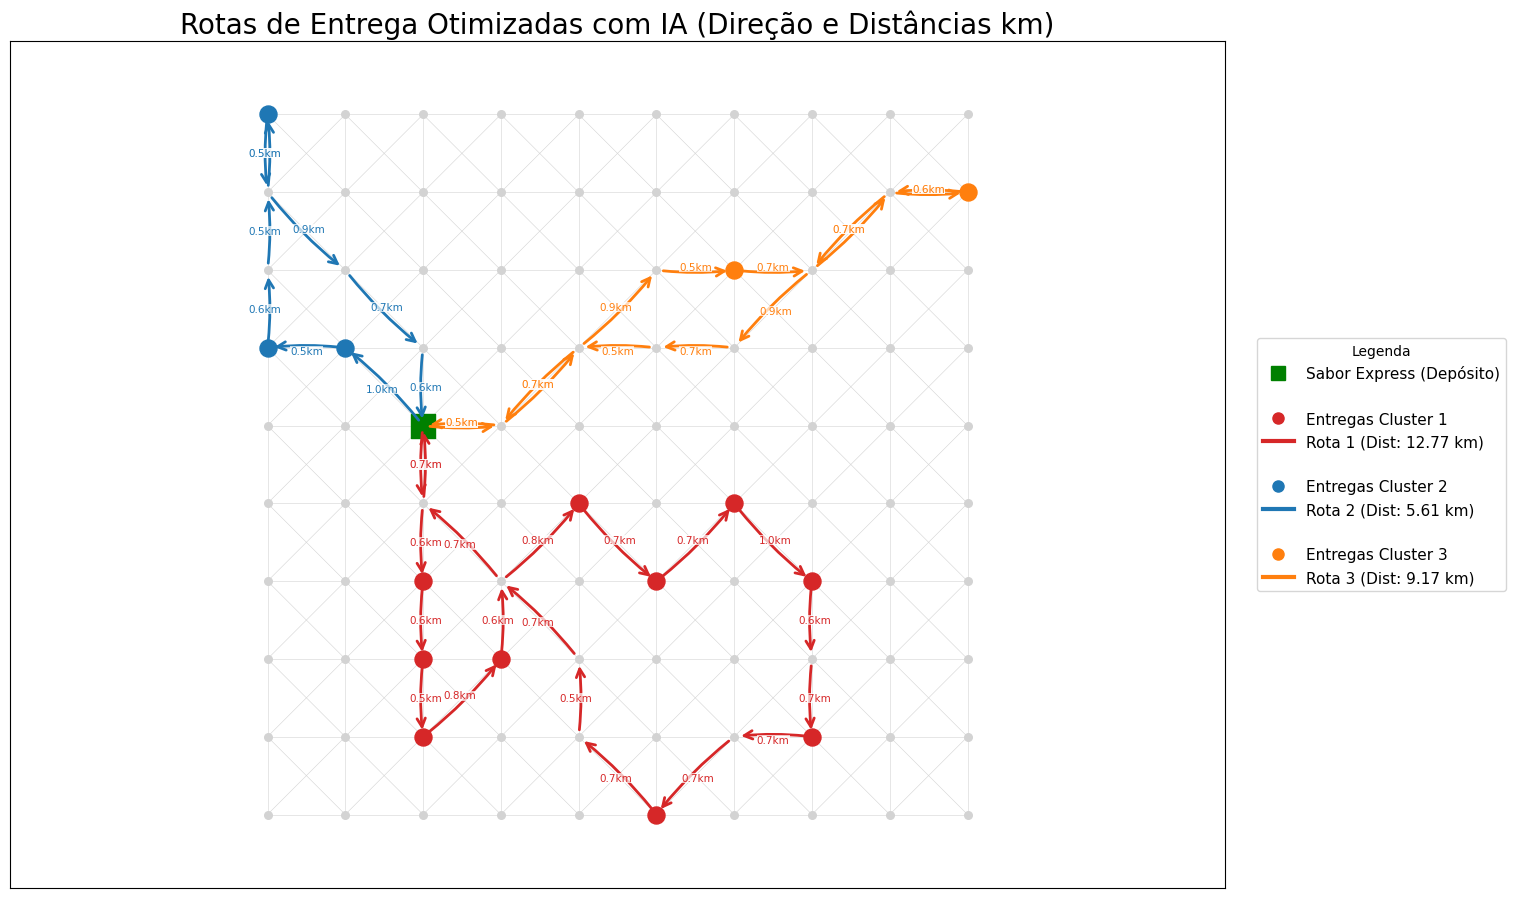


--- Análise dos Resultados ---
Distância total percorrida por todos os entregadores: 27.56 km.
A solução dividiu os pontos de entrega em zonas eficientes e traçou a rota mais curta (em km) para cada uma, indicando a direção.
Benefícios: Redução do tempo total de entrega, economia de combustível e potencial aumento da satisfação do cliente.


In [259]:
plt.figure(figsize=(18, 11))
ax = plt.gca()

# Desenha nós e arestas base do grafo
nx.draw_networkx_nodes(G, pos, node_size=30, node_color='lightgray', ax=ax)
nx.draw_networkx_edges(G, pos, width=0.4, edge_color='lightgray', ax=ax)

# Desenha os nós de entrega (coloridos por cluster)
for i in range(num_clusters):
    nx.draw_networkx_nodes(G, pos, nodelist=clustered_deliveries[i], node_color=colors[i], node_size=150, ax=ax)

# Desenha o depósito
nx.draw_networkx_nodes(G, pos, nodelist=[depot_node], node_color='green', node_size=300, node_shape='s', ax=ax)
edge_label_sides = {}

# Desenha as rotas otimizadas com SETAS
for i, route in enumerate(optimized_routes):
    path_edges = list(zip(route, route[1:]))

    # Desenha setas para indicar a direção da rota
    for u, v in path_edges:
        ax.annotate("",
                    xy=pos[v], xycoords='data',
                    xytext=pos[u], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color=colors[i],
                                    shrinkA=5, shrinkB=5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=0.06",
                                    lw=2,
                                    mutation_scale=15
                                    ),
                    alpha=0.8
                   )
    label_offset = 0.04
    for u, v in path_edges:
        pos_u = np.array(pos[u])
        pos_v = np.array(pos[v])
        mid_point = (pos_u + pos_v) / 2

        direction = pos_v - pos_u
        if np.linalg.norm(direction) == 0: continue
        perp_direction = np.array([-direction[1], direction[0]])
        norm_perp = perp_direction / np.linalg.norm(perp_direction)
        edge_key = tuple(sorted((u, v)))
        if edge_key in edge_label_sides:
            side = -edge_label_sides[edge_key]
            edge_label_sides[edge_key] = side
        else:
            side = 1
            edge_label_sides[edge_key] = side
        label_pos = mid_point + norm_perp * label_offset * side

        weight = G.edges[u, v]['weight']
        label_text = f"{weight:.1f}km"

        ax.text(label_pos[0], label_pos[1], label_text,
                size=7.5,
                color=colors[i],
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.1)
               )

# Criação da legenda detalhada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', marker='s', linestyle='None', markersize=10, label='Sabor Express (Depósito)'),
    Line2D([0], [0], color='w', marker='o', linestyle='None', markersize=0),

    Line2D([0], [0], color=colors[0], marker='o', linestyle='None', markersize=8, label=f'Entregas Cluster 1'),
    Line2D([0], [0], color=colors[0], lw=3, label=f'Rota 1 (Dist: {total_distances[0]:.2f} km)'),
    Line2D([0], [0], color='w', marker='o', linestyle='None', markersize=0),

    Line2D([0], [0], color=colors[1], marker='o', linestyle='None', markersize=8, label=f'Entregas Cluster 2'),
    Line2D([0], [0], color=colors[1], lw=3, label=f'Rota 2 (Dist: {total_distances[1]:.2f} km)'),
    Line2D([0], [0], color='w', marker='o', linestyle='None', markersize=0),

    Line2D([0], [0], color=colors[2], marker='o', linestyle='None', markersize=8, label=f'Entregas Cluster 3'),
    Line2D([0], [0], color=colors[2], lw=3, label=f'Rota 3 (Dist: {total_distances[2]:.2f} km)')
]

plt.title("Rotas de Entrega Otimizadas com IA (Direção e Distâncias km)", fontsize=20)
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), loc='center left', title="Legenda", fontsize=11)
plt.subplots_adjust(right=0.8)
plt.axis('equal')
plt.show()

# Análise Resumida dos Resultados
print("\n--- Análise dos Resultados ---")
print(f"Distância total percorrida por todos os entregadores: {sum(total_distances):.2f} km.")
print("A solução dividiu os pontos de entrega em zonas eficientes e traçou a rota mais curta (em km) para cada uma, indicando a direção.")
print("Benefícios: Redução do tempo total de entrega, economia de combustível e potencial aumento da satisfação do cliente.")